In [1]:
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, LSTM, GRU, SimpleRNN, Embedding
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import plot_model, model_to_dot
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from datetime import datetime
from IPython.display import Image
from statsmodels.tsa.arima_model import ARIMA
from sklearn import preprocessing
from collections import deque
import numpy as np
import random
import os
%run WordEmbeddings.ipynb
%run ARIMA-creator.ipynb

In [2]:
def smooth_data(data,indices):
    """Interpolate/average financial data where values are missing. 
    
    Parameters: 
    data - A pandas dataframe indexed by datetime
    indices - Datetime indices of the values to interpolate to. 
    
    Returns: 
    A pandas dataframe
    """
    
    start_date = indices[0]
    end_date = indices[-1]
    temp = pd.DataFrame({'data':[], 'date':[]})
    n_interpol = 0
    for i, date in enumerate(indices): 
        if date not in data.index: 
            n_interpol += 1
            prev_valid = date
            next_valid = date
            while prev_valid not in data.index:
                prev_valid = prev_valid - timedelta(days=1)
                if prev_valid < start_date: 
                    prev_valid = data.index[0]
                    break
            while next_valid not in data.index: 
                next_valid = next_valid + timedelta(days=1)
                if next_valid > end_date: 
                    next_valid = data.index[-1]
                    break
            rate = (data.loc[prev_valid] + data.loc[next_valid]) / 2
            temp = temp.append({'data':rate,'date':date},ignore_index=True)
        else: 
            temp = temp.append({'data': data.loc[date],'date':date},ignore_index=True)
    print("{} interpolated values of {} total.".format(n_interpol, len(indices)))
    temp.set_index('date',inplace=True)
    return temp

def interpolate_indices(data,indices): 
    start_date = indices[0]
    end_date = indices[-1]
    merged_df = pd.DataFrame({'data':data.values, 'date':data.index})
    n_interpol = 0
    for i, date in enumerate(indices):
        if date not in data.index: 
            n_interpol += 1
            prev_valid = date
            next_valid = date
            while prev_valid not in data.index:
                prev_valid = prev_valid - timedelta(days=1)
                if prev_valid < start_date: 
                    prev_valid = data.index[0]
                    break
            while next_valid not in data.index: 
                next_valid = next_valid + timedelta(days=1)
                if next_valid > end_date: 
                    next_valid = data.index[-1]
                    break
            val = (data.loc[prev_valid] + data.loc[next_valid]) / 2
            merged_df = merged_df.append({'data':val,'date':date},ignore_index=True)
    print("{} interpolated values of {} total.".format(n_interpol, len(indices)))
    merged_df.set_index('date',inplace=True)
    return merged_df


def generator(data, arima_data, fin_data, lookback, delay, indices, batch_size=32):
    """ Creates a generator for the given data. Returns each 
    batch with separate word embeddings and ARIMA-predictions. 
    
    Parameters: 
    data - Sorted data of size (n,d)
    arima_data - Predictions from the arima-models 
    lookback - How far back to include data (days)
    delay - How far ahead to predict (days)
    indices - Shuffled indices to include, where the order is followed
    batch_size - How many samples to return each call 
    
    Returns: 
    samples_words - Word-related data 
    samples_arima - The ARIMA-predicted future value 
    targets - The value of the times series delay days ahead
    
    """
    min_index = lookback
    max_index = len(data) - delay - 1
    current_batch_start = 0
    while True:
        if current_batch_start > len(indices): 
            current_batch_start = 0
        rows = indices[current_batch_start:min(current_batch_start+batch_size,max_index)]
        current_batch_start += batch_size
        samples_words = np.zeros((len(rows), lookback, data.shape[-1]))
        samples_arima = np.zeros(len(rows),)
        targets = np.zeros(len(rows),)
        dates = []
        for i, index in enumerate(rows): 
            date = arima_data.index[index]
            dates.append(date)
            target_date = date + timedelta(days=delay)     # Does this always give a viable date? 
            if (index > min_index) and (index < max_index):
                samples_words[i] = data[range(index - lookback,index)]
                samples_arima[i] = arima_data[date]
                targets[i] = fin_data.loc[target_date]
        yield [samples_words, samples_arima], targets

def preprocess_df(df,par):
    """ Shift the actual values 'delay' steps so that they are targets in the 
    correct row of the data frame.
    Normalize so that the numerical data is in the interval [0,1]. 
    """
    df['1 YEAR'].shift(-par['delay'])
    df['3 YEAR'].shift(-par['delay'])
    df['S&P'].shift(-par['delay'])
    df.dropna(inplace=True)
    for col in df.columns:
        if col != 'WORDS':
            df.dropna(inplace=True)
            df[col] = preprocessing.scale(df[col].values)
    return df

def format_for_training(df,par):
    sequential_data = []
    prev_data = deque(maxlen=par['lookback'])
    for i in df.values: 
        prev_data.append(i[0])
        if len(prev_data) == par['lookback']: 
            if par['series'] == '1 YEAR': 
                sequential_data.append([np.array(prev_data), i[4], i[1]])
            elif par['series'] == '3 YEAR': 
                sequential_data.append([np.array(prev_data), i[5], i[2]])
            elif par['series'] == 'S&P': 
                sequential_data.append([np.array(prev_data), i[6], i[3]])
    random.shuffle(sequential_data)
    x_words = []
    x_arima = []
    y = []
    for row in sequential_data: 
        x_words.append(row[0])
        x_arima.append(row[1])
        y.append(row[2])
    return np.asarray(x_words), np.asarray(x_arima), np.asarray(y)
    
    

In [3]:
# Set up hyperparameters to be saved in a config file later. 
par = {
    'embed_dim': 100,    # Dimensions to use for the word embedding
    'concat_period': 1,  # How many days to concatinate new from 
    'vocab_part': 0.6,   # How large part of the total vocabulary to include
    'lookback': 20,       # How far back to collect data in the recurrent layer (days)
    'delay': 5,          # How far ahead to predict data (days)
    'batch_size': 10,    # Batch size used in generator
    'p': 1,              # Order of the AR-part of the model
    'd': 1,              # Integrated order
    'q': 1,              # Included moving average terms 
    'train_part' : 0.6,  # Part of data to be used for training
    'val_part' : 0.2,    # Part of data to be used for validation
    'test_part' : 0.2,   # Part of data to be used for testing
    'series': '1 YEAR'   # What series we currently want to predict, '1 YEAR', '3 YEAR' or 'S&P'
}

In [4]:
# Initialize logging folder for TensorBoard
logdir=Path("./logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [5]:
# Load and process text data 
t = time.time()
path_text = Path("./Datasets/data/financial_headlines_20061020-20131119.pkl")
news_data = pd.DataFrame(pd.read_pickle(path_text))
news_data.set_index('date',inplace=True)
data = concat_news(news_data, par['concat_period']) 
max_length = max([len(line) for line in data['titles']])
print("Time to load news: {} s".format(round(time.time() - t,3)))
t = time.time()
# Update environment variable config
par.update({'input_dim': max_length})
par.update({'start_date' : news_data.index[0]})
par.update({'end_date' : news_data.index[-1]})


# Calculate number of uniques words. 
uniques = set()
for d in data['titles']:
    [uniques.add(word) for word in d]

print("Time to calculate unique words: {} s".format(round(time.time() - t,3)))
par.update({'vocab_size': round(par['vocab_part']*len(uniques))})

Time to load news: 17.328 s
Time to calculate unique words: 0.172 s


In [6]:
# Dataframe containing all data
df = pd.DataFrame()
# Prepare the data as integer encoded and pad with zeroes after entries where needed. 
encoded_data = [one_hot(str(d),par['vocab_size']) for d in data['titles']]
x_words = pad_sequences(encoded_data,maxlen=par['input_dim'],padding='post')
for x in x_words: 
    df = df.append({'WORDS': x},ignore_index=True)
n,d = x_words.shape

In [7]:
# Load and process the financial time series 
path_ts = Path("./Datasets/data/stock_data.pkl")
fin_data = pd.read_pickle(path_ts)

# Extract the times and series we are interested in
one_year = fin_data['1 YEAR'][par['start_date'] : par['end_date']]
three_year = fin_data['3 YEAR'][par['start_date'] : par['end_date']]
SP = fin_data['S&P'][par['start_date'] : par['end_date']]

In [8]:
# Interpolate the indices not present in the original data
print("Processing one year rate...")
one_year = interpolate_indices(one_year,data.index)
print("Processing three year rate...")
three_year = interpolate_indices(three_year,data.index)
print("Processing S&P...")
SP = interpolate_indices(SP,data.index)

# Add to the dataframe 
df['1 YEAR'] = ([one_year.loc[d][0] for d in data.index])
df['3 YEAR'] = ([three_year.loc[d][0] for d in data.index])
df['S&P'] = ([SP.loc[d][0] for d in data.index])
df['date'] = data.index.values
df.set_index('date',inplace=True)


# Set period as daily data
#one_year.index = pd.DatetimeIndex(one_year.index).to_period('D')
#three_year.index= pd.DatetimeIndex(three_year.index).to_period('D')
#SP_log.index = pd.DatetimeIndex(SP_log.index).to_period('D')

Processing one year rate...
740 interpolated values of 2587 total.
Processing three year rate...
740 interpolated values of 2587 total.
Processing S&P...
740 interpolated values of 2587 total.


In [9]:
# Check if the ARIMA-models has been previously calculated for this config
# or if they have to be constructed
path = Path(f"./Models/ARIMA/all_mods_per{par['concat_period']}_del{par['delay']}.pkl")
if os.path.exists(path):
    # Load model if if already exists
    ARIMA_models = pd.read_pickle(path)    
    print("Found and loaded previously constructed model.")
else: 
    # Fit ARIMA-models to all of the dates in the training data 
    print("Model not found, fitting models...")
    ARIMA_models = fit_all_models(par, one_year, three_year, SP, data.index)
    ARIMA_models.to_pickle(path)    

Found and loaded previously constructed model.


In [10]:
# Predict 
arima_preds = predict_arima(ARIMA_models, par['delay'])

In [11]:
# Drop the values not in arima_preds. This is just values in the beginning where
# there isn't enough data to make a prediction, varies depending on lookback and delay. 
for date in df.index: 
    if not date in arima_preds.index : df.drop(index=date,inplace=True)
        
# Add the predicitons to the training data 
df['1 YEAR PRED'] = arima_preds['1 YEAR'].values
df['3 YEAR PRED'] = arima_preds['3 YEAR'].values
df['S&P PRED'] = arima_preds['S&P'].values

In [12]:
# Preprocess the data with scaling, removing NaN's etc
df = preprocess_df(df, par)

# Divide the data into training, validation and test segments. 
indices = [i for i in range(len(df))]
train_indices = indices[0:round(len(df)*par['train_part'])]
val_indices = indices[round(len(df)*par['train_part']):round(len(df)*(par['train_part'] + par['val_part']))]
test_indices = indices[round(len(df)*(par['train_part'] + par['val_part'])): len(df)]

# Formats the data into (word, ARIMA-prediction, target), shuffled
train_seq, train_arima, train_label = format_for_training(df.iloc[train_indices],par)
val_seq, val_arima, val_label = format_for_training(df.iloc[val_indices],par)
test_seq, test_arima, test_label = format_for_training(df.iloc[test_indices],par)

In [13]:
# This only takes the first samples from 'WORDS', i.e. doesn't take the order into account
train = []
val = []
for i in range(2000): 
    train.append([df.iloc[i]['WORDS'],df.iloc[i]['1 YEAR PRED'],df.iloc[i]['1 YEAR']])
for i in range(2000,len(df)): 
    val.append([df.iloc[i]['WORDS'],df.iloc[i]['1 YEAR PRED'],df.iloc[i]['1 YEAR']])
train = np.asarray(train)
val = np.asarray(val)

In [14]:
x1 = []
x2 = []
y = []
for i in train: 
    x1.append(i[0])
    x2.append(i[1])
    y.append(i[2])
x1 = np.asarray(x1)
x2 = np.asarray(x2)
y = np.asarray(y)

vx1 = []
vx2 = []
vy = []
for i in val: 
    vx1.append(i[0])
    vx2.append(i[1])
    vy.append(i[2])
vx1 = np.asarray(vx1)
vx2 = np.asarray(vx2)
vy = np.asarray(vy)

In [15]:
# Initialize the neural network
text_inputs = Input(shape=(par['input_dim']), name='Text_Input')

# Layer for word embedding
embedded_layer = Embedding(input_dim=par['vocab_size'],
                           output_dim=par['embed_dim'],
                           input_length=(par['input_dim']), name='Embedding_Layer')(text_inputs)

# LSTM-layer over the embedding layer 
lstm_out = LSTM(10)(embedded_layer)
dropout = Dropout(0.2)(lstm_out)

# Output from the LSTM-layer to be able to train embeddings separately (?)
#auxiliary_output = Dense(1,activation='sigmoid', name='AUX_output')(lstm_out)

# Input from an ARIMA-model independently fitted to the training data. 
ARIMA_input = Input(shape=(1,), name='ARIMA_input')

# Merging the ARIMA-input and the input from the LSTM-layer. 
hidden = keras.layers.concatenate([dropout, ARIMA_input])

# Stack of dense layers 
hidden = Dense(64, activation='relu',name='Dense_1')(hidden)
hidden = Dropout(0.2)(hidden)

hidden = Dense(64, activation='relu',name='Dense_2')(hidden)
hidden = Dropout(0.2)(hidden)

# Main output of the model
main_output = Dense(1,activation='linear',name='Main_Output')(hidden)

model = Model(inputs=[text_inputs, ARIMA_input],outputs=[main_output])

model.compile(optimizer='adam',
             loss='mse')
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Text_Input (InputLayer)         [(None, 2419)]       0                                            
__________________________________________________________________________________________________
Embedding_Layer (Embedding)     (None, 2419, 100)    1375700     Text_Input[0][0]                 
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 10)           4440        Embedding_Layer[0][0]            
__________________________________________________________________________________________________
dropout (Dropout)               (None, 10)           0           lstm[0][0]                       
______________________________________________________________________________________________

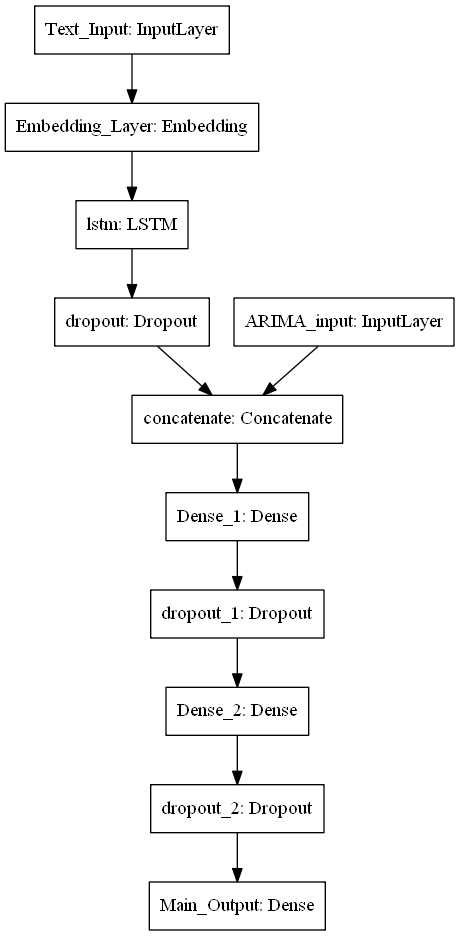

In [16]:
plot_model(model)

In [17]:
h = model.fit({'Text_Input': np.asarray(x1), 'ARIMA_input': np.asarray(x2)},
              {'Main_Output': y},
              validation_data=({'Text_Input': np.asarray(vx1), 'ARIMA_input': np.asarray(vx2)},
              {'Main_Output': vy}),
              batch_size=par['batch_size'],
              epochs=5)

Train on 2000 samples, validate on 566 samples
Epoch 1/5
2000/2000 [==============================] - 245s 122ms/sample - loss: 0.1817 - val_loss: 7.8407e-04
Epoch 2/5
2000/2000 [==============================] - 241s 120ms/sample - loss: 0.0336 - val_loss: 8.3807e-04
Epoch 3/5
2000/2000 [==============================] - 260s 130ms/sample - loss: 0.0270 - val_loss: 0.0019
Epoch 4/5
2000/2000 [==============================] - 315s 157ms/sample - loss: 0.0278 - val_loss: 0.0013
Epoch 5/5
2000/2000 [==============================] - 363s 182ms/sample - loss: 0.0265 - val_loss: 1.5188e-04


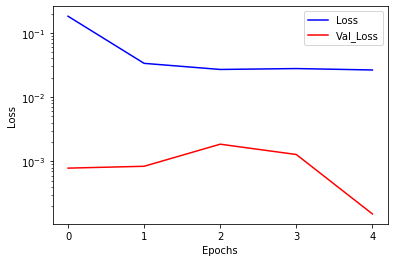

In [29]:
plt.plot(h.history['loss'],color="blue",label="Loss")
plt.plot(h.history['val_loss'],color="red",label="Val_Loss")
plt.legend()
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.xticks(range(5))
plt.show()

In [92]:
# Save model and parameters
date_str = date.today().strftime("%y%h%d-%Hh%Mm")
dir_path = Path(f"./Models/model_per_{par['concat_period']}_del_{par['delay']}_t{date_str}")
os.mkdir(dir_path)
model_path = dir_path / "m.h5"
model.save(model_path)
config_path = dir_path / "config.pkl"